<a href="https://colab.research.google.com/github/CarbonErmiyasdaniel/plant-disease-detection-vgg16/blob/main/plant_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install tensorflow gradio -q

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
import tensorflow_datasets as tfds

# Load the beans dataset
(train_ds, val_ds, test_ds), info = tfds.load(
    "beans",
    split=['train', 'validation', 'test'],
    as_supervised=True,
    with_info=True
)

print("Classes:", info.features['label'].names)
print("Training samples:", info.splits['train'].num_examples)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.1WN0Q2_0.1.0/beans-train.tfrecord*...:   0%|          | 0…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.1WN0Q2_0.1.0/beans-validation.tfrecord*...:   0%|        …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.1WN0Q2_0.1.0/beans-test.tfrecord*...:   0%|          | 0/…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
Training samples: 1034


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0  # normalize
    return image, label

train_ds = train_ds.map(format_image).batch(BATCH_SIZE).shuffle(1000)
val_ds = val_ds.map(format_image).batch(BATCH_SIZE)
test_ds = test_ds.map(format_image).batch(BATCH_SIZE)


In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 502ms/step - accuracy: 0.4279 - loss: 4.0695 - val_accuracy: 0.7218 - val_loss: 0.7326
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.7439 - loss: 0.5962 - val_accuracy: 0.8045 - val_loss: 0.5143
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.8022 - loss: 0.4896 - val_accuracy: 0.8421 - val_loss: 0.4525
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.8692 - loss: 0.3478 - val_accuracy: 0.8195 - val_loss: 0.4347
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.8776 - loss: 0.2998 - val_accuracy: 0.7970 - val_loss: 0.4235
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.9269 - loss: 0.2259 - val_accuracy: 0.8195 - val_loss: 0.4108
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9445 - loss: 0.1828 - val_accuracy: 0.8421 - val_loss: 0.4171
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9578 - loss: 0.1577 - val_accuracy: 0

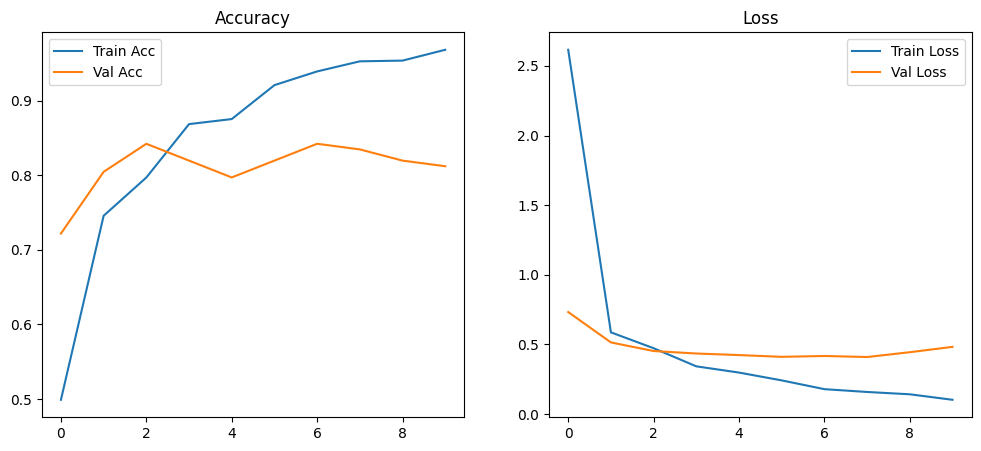

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [7]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=info.features['label'].names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
                   precision    recall  f1-score   support

angular_leaf_spot       0.83      0.81      0.82        43
        bean_rust       0.77      0.84      0.80        43
          healthy       0.97      0.90      0.94        42

         accuracy                           0.85       128
        macro avg       0.86      0.85      0.85       128
     weighted avg       0.86      0.85      0.85       128



In [8]:
model.save("plant_disease_vgg16.h5")
print("✅ Model saved as plant_disease_vgg16.h5")


✅ Model saved as plant_disease_vgg16.h5


In [13]:
import tensorflow as tf
import numpy as np
import gradio as gr

# Reload model if needed
model = tf.keras.models.load_model("plant_disease_vgg16.h5")  # Or skip if already in memory

# Define constants
IMG_SIZE = (224, 224)
class_names = ['angular_leaf_spot', 'bean_rust', 'healthy']

# Descriptions for better output
descriptions = {
    "angular_leaf_spot": "Angular Leaf Spot: This is a fungal disease. The leaves have brown spots with yellow edges. It often happens in humid conditions. Recommended action: Improve air circulation and consider fungicide treatment.",
    "bean_rust": "Bean Rust: This is a fungal infection that shows orange or rust-colored spots on the leaves. It reduces the plant's ability to make food. Recommended action: Remove infected leaves and apply fungicides.",
    "healthy": "Healthy Leaf: The leaf looks good with no signs of disease. Keep up the good care!"
}

def predict_bean(image):
    try:
        # Ensure image is valid
        if image is None:
            return "No image uploaded.", "", ""

        img = tf.image.resize(image, IMG_SIZE)
        img = tf.expand_dims(img, 0) / 255.0
        pred = model.predict(img)
        result = class_names[np.argmax(pred)]
        confidence = float(np.max(pred))
        description = descriptions[result]
        return result, f"{confidence*100:.2f}%", description
    except Exception as e:
        return "Error", "Error", str(e)

demo = gr.Interface(
    fn=predict_bean,
    inputs=gr.Image(type="numpy", label="Upload a bean leaf image"),
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Textbox(label="Confidence"),
        gr.Textbox(label="Description")
    ],
    title="🌿 Bean Disease Detection (VGG16 Transfer Learning)",
    description="Upload a bean leaf image to detect if it's healthy or diseased. The system identifies Angular Leaf Spot, Bean Rust, or Healthy leaves."
)

demo.launch()





It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://704c4e96add1c95901.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [10]:
print("✅ Project Summary")
print("----------------------------")
print("Model: VGG16 Transfer Learning")
print("Dataset: TensorFlow Beans (3 classes)")
print("Performance Metric: Accuracy, F1-score")
print("Demo: Gradio Web Interface")
print("Training completed successfully!")


✅ Project Summary
----------------------------
Model: VGG16 Transfer Learning
Dataset: TensorFlow Beans (3 classes)
Performance Metric: Accuracy, F1-score
Demo: Gradio Web Interface
Training completed successfully!
